# **ML Lifecycle**
### This notebook combines the analysis, cleaning, preprocessing, visualization, pipeline generation and model training process into functions that can be used for different datasets

#### Dataset features must include - "processed_text", "priority", "urgency"

In [326]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report

from sklearn.model_selection import cross_val_score, StratifiedKFold



In [332]:
df = pd.read_csv('../csv/oversampled_data.csv')
df.sample(3)

,label,processed_text,priority,urgency,type,queue
3938,0.0,Issues with the registration of new accounts,low,not_urgent,NaN,NaN
6357,0.0,Delayed replication of non-critical data acros...,low,not_urgent,NaN,NaN
3674,0.0,Performance lag observed when multiple chats a...,low,not_urgent,NaN,NaN


## Analysis

In [328]:
def analysis(df):
    print(f'Shape : {df.shape}\n')
    print(f'Columns : {df.columns}\n')
    print(f"Sample: \n{df.sample(3)}\n")
    print(f"Null values: \n{df.isnull().sum()}\n")

analysis(df)

Shape : (11068, 6)

Columns : Index(['label', 'processed_text', 'priority', 'urgency', 'type', 'queue'], dtype='object')

Sample: 
      label                                     processed_text priority  \
89      0.0                    This is not worth fussing over.      low   
6397    0.0  Minor disruptions in service during non-critic...      low   
2103    2.0  Critical update for crash when changing langua...     high   

         urgency type queue  
89    not_urgent  NaN   NaN  
6397  not_urgent  NaN   NaN  
2103      urgent  NaN   NaN  

Null values: 
label             3983
processed_text       0
priority             0
urgency              0
type              9512
queue             9512
dtype: int64



## Cleaning

In [333]:
def clean_data(df):
    df = df[['processed_text', 'priority', 'urgency']]
    df = df.rename(columns={'processed_text': 'text'})
    df['label'] = df['urgency'].apply(lambda x: 1 if x == 'urgent' else 0)
    return df 

df = clean_data(df)
df.sample(3)

,text,priority,urgency,label
3054,Immediate Remedy: Incorrect last seen time dis...,high,urgent,1
2597,Page navigation buttons inactive in the employ...,low,not_urgent,0
10262,Critical: Breakpoint. This is a operational fr...,High,urgent,1


## Visualization - using TF-IDF Vectorizer

In [334]:
def word_importance_chart(ax, df, title):
    tdidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
    tdidf_matrix = tdidf_vectorizer.fit_transform(df['text'])
    
    
    feature_names = tdidf_vectorizer.get_feature_names_out()
    word_scores = zip(feature_names, tdidf_matrix.sum(axis=0).tolist()[0])

    top_words = sorted(word_scores, key=lambda x: x[1], reverse=True)[:10]
    
    keywords, frequencies = zip(*top_words)
    
    ax.barh(keywords, frequencies)
    ax.set_title(title)
    ax.set_xlabel('Frequency')
    ax.set_ylabel('Keyword')
    ax.invert_yaxis()

In [288]:
def distribution_chart(ax, df, column, title, category):
    sns.countplot(data=df, x=column, ax=ax)
    ax.set_title(title)

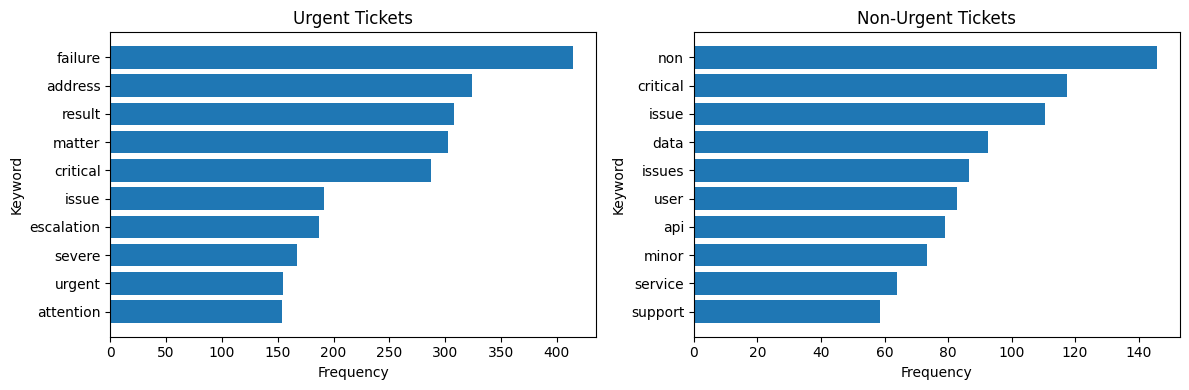

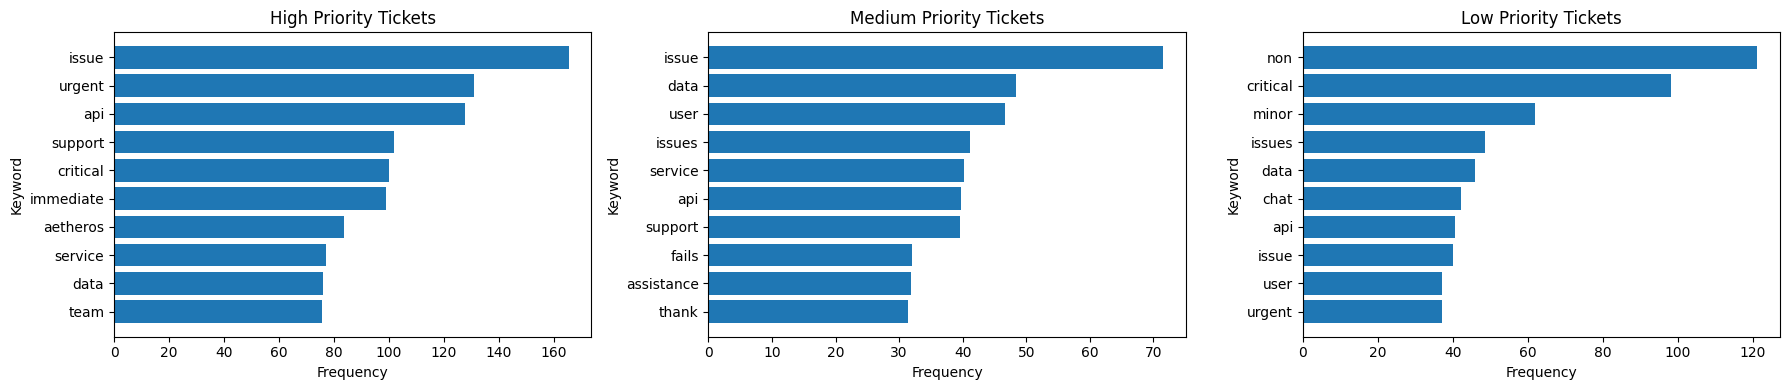

In [289]:
urgent_df = df[df['urgency'] == 'urgent']
non_urgent_df = df[df['urgency'] == 'not_urgent']

high_priority_df = df[df['priority'] == 'high']
medium_priority_df = df[df['priority'] == 'medium']
low_priority_df = df[df['priority'] == 'low']

# Urgent/Non-Urgent Tickets
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
word_importance_chart(axs[0], urgent_df, 'Urgent Tickets')
word_importance_chart(axs[1], non_urgent_df, 'Non-Urgent Tickets')
plt.tight_layout()

# Priority Tickets
fig, axs = plt.subplots(1, 3, figsize=(18, 4))
word_importance_chart(axs[0], high_priority_df, 'High Priority Tickets')
word_importance_chart(axs[1], medium_priority_df, 'Medium Priority Tickets')
word_importance_chart(axs[2], low_priority_df, 'Low Priority Tickets')
plt.tight_layout()


urgency
not_urgent    5669
urgent        5399
Name: count, dtype: int64

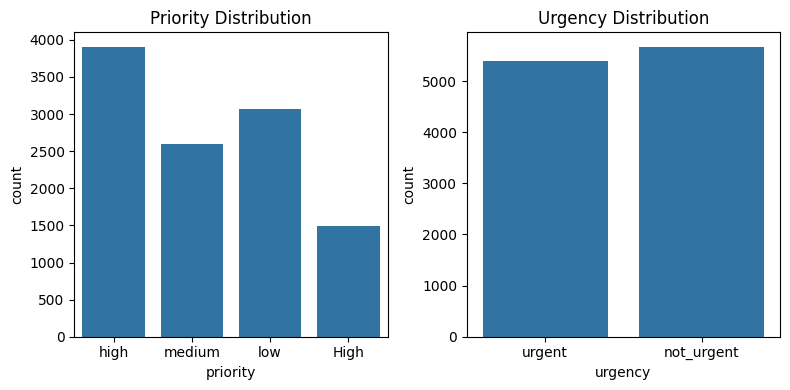

In [290]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
distribution_chart(axs[0], df, 'priority', 'Priority Distribution', 'priority')
distribution_chart(axs[1], df, 'urgency', 'Urgency Distribution', 'urgency')
plt.tight_layout()

# print number of urgent and non-urgent tickets
df['urgency'].value_counts()

# **Using Priority**

## Train-Test Split 

In [291]:
def get_train_test_data(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    print(f"X_train shape: {X_train.shape}")
    print(f"X_test shape: {X_test.shape}")
    return X_train, X_test, y_train, y_test

In [292]:
X_train, X_test, y_train, y_test = get_train_test_data(df[['text']], df['priority'])

X_train shape: (8854, 1)
X_test shape: (2214, 1)


## Model Training - using Pipeline

In [456]:
# Training the models
def train_model(model, tdidf_vectorizer, X_train, y_train, X_test, y_test):
    text_transformer = Pipeline([
    ('tfidf', tdidf_vectorizer)
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('text_tfidf', text_transformer, 'text')
        ],
    )
    pipeline =Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    print(f"Classification Report: \n{classification_report(y_test, y_pred)}")
    return pipeline

In [401]:
# Logisitic Regression
pipeline_logreg = train_model(
    LogisticRegression(random_state=42, max_iter=1000), 
    TfidfVectorizer(),
    X_train, 
    y_train,
    X_test,
    y_test
)

Classification Report: 
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       298
        high       0.86      0.85      0.85       764
         low       0.75      0.81      0.78       629
      medium       0.62      0.57      0.59       523

    accuracy                           0.79      2214
   macro avg       0.81      0.81      0.81      2214
weighted avg       0.79      0.79      0.79      2214



In [457]:
# Support Vector Machine
pipeline_svm = train_model(
    SVC(random_state=42), 
    TfidfVectorizer(),
    X_train, 
    y_train,
    X_test,
    y_test
)

Classification Report: 
              precision    recall  f1-score   support

        High       1.00      1.00      1.00       298
        high       0.90      0.83      0.87       764
         low       0.75      0.83      0.79       629
      medium       0.63      0.62      0.63       523

    accuracy                           0.81      2214
   macro avg       0.82      0.82      0.82      2214
weighted avg       0.81      0.81      0.81      2214



## Testing with example texts

In [296]:
# Example of prediction
example_text = pd.DataFrame([
   'This is an urgent issue',
    'I need help with my account right now without delay',
    'I have a question about my account',
    'I cannot access my account. Please help me',
    'I am unable to access my account. I have tried resetting my password but it is not working. I need help urgently',
    "Query regarding my account. Please help me",
    "The server is down. Please fix it as soon as possible",
    "System Issue. Need help before the end of the day",
    "Jira tickets need to be updated. Please do it as soon as possible. no hurry",
    "Not Critical. Please ensure system is up and running without any issues before the end of the day.",
    ],
    columns=['text']
)

print(f"Logistic Regression Prediction: \n{pipeline_logreg.predict(example_text)}")
print(f"SVM Prediction: \n{pipeline_svm.predict(example_text)}")


Logistic Regression Prediction: 
['high' 'high' 'medium' 'medium' 'medium' 'medium' 'high' 'high' 'medium'
 'low']
SVM Prediction: 
['high' 'low' 'medium' 'medium' 'medium' 'medium' 'medium' 'high' 'low'
 'low']


# **Using Urgency**

## Train-Test Split 

In [403]:
X = df[['text']]
y = df['label']
X_train_urgency, X_test_urgency, y_train_urgency, y_test_urgency = get_train_test_data(X, y)

X_train shape: (8854, 1)
X_test shape: (2214, 1)


## Model Training - using Pipeline

In [405]:
# Logisitic Regression
pipeline_logreg = train_model(
    LogisticRegression(random_state=42, max_iter=1000), 
    TfidfVectorizer(),
    X_train_urgency, 
    y_train_urgency,
    X_test_urgency,
    y_test_urgency
) 

Classification Report: 
              precision    recall  f1-score   support

           0       0.86      0.95      0.91      1152
           1       0.94      0.84      0.89      1062

    accuracy                           0.90      2214
   macro avg       0.90      0.89      0.90      2214
weighted avg       0.90      0.90      0.90      2214



In [407]:
# Support Vector Machine
pipeline_svm = train_model(
    SVC(random_state=42, kernel='linear'),
    TfidfVectorizer(), 
    X_train_urgency,
    y_train_urgency,
    X_test_urgency,
    y_test_urgency
)

Classification Report: 
              precision    recall  f1-score   support

           0       0.88      0.94      0.91      1152
           1       0.93      0.86      0.90      1062

    accuracy                           0.90      2214
   macro avg       0.91      0.90      0.90      2214
weighted avg       0.91      0.90      0.90      2214



In [470]:

example_text = pd.DataFrame([
   'This is an urgent issue',
    'I need help with my account right now without delay',
    'I have a question about my account',
    'I cannot access my account. Please help me',
    'I am unable to access my account. I have tried resetting my password but it is not working. I need help urgently',
    "Query regarding my account. Please help me",
    "The server is down. Please fix it as soon as possible",
    "System Issue. Need help before the end of the day",
    "Jira tickets need to be updated. Please do it as soon as possible. no hurry",
    "Not Critical. Please ensure system is up and running without any issues before the end of the day.",
    ],
    columns=['text']
)

print(f"Logistic Regression Prediction: \n{pipeline_logreg.predict(example_text)}\n")
print(f"SVM Prediction: \n{pipeline_svm.predict(example_text)}")

Logistic Regression Prediction: 
[1 0 0 1 0 0 1 0 0 0]

SVM Prediction: 
['high' 'low' 'medium' 'medium' 'medium' 'medium' 'medium' 'high' 'low'
 'low']


# Cross Validation using K-Fold

In [409]:

# Function to train and validate the model using K-Fold Cross-Validation
def cross_validate_model(model, tfidf_vectorizer, X, y, cv=5, scoring='precision'):
    text_transformer = Pipeline([
        ('tfidf', tfidf_vectorizer)
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('text_tfidf', text_transformer, 'text')
        ],
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Stratified K-Fold to maintain class distribution
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    # Use cross_val_score to evaluate accuracy
    scores = cross_val_score(
        pipeline, 
        X, 
        y, 
        cv=skf, 
        scoring=scoring
    )

    print(f"Cross-Validation {scoring.capitalize} Scores: {scores}")
    print(f"Mean: {np.mean(scores):.4f}")
    print(f"Standard Deviation: {np.std(scores):.4f}")

    return scores


In [377]:
# Testing accuracy
scored_svm = cross_validate_model(
    SVC(random_state=42, kernel='linear'), 
    TfidfVectorizer(),
    df[['text']], 
    df['urgency'].map({'urgent': 1, 'not_urgent': 0})
)

Cross-Validation <built-in method capitalize of str object at 0x1027bd0b0> Scores: [0.93170234 0.93865031 0.92987805 0.934      0.93699187]
Mean: 0.9342
Standard Deviation: 0.0032


## Fine Tuning - using GridSearchCV

In [379]:
from sklearn.model_selection import GridSearchCV

def hyperparameter_tuning(model, X_train, y_train, param_grid):
    text_transformer = Pipeline([
        ('tfidf', TfidfVectorizer())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('text_tfidf', text_transformer, 'text')
        ],
    )

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='precision',
        verbose=2
    )
    grid_search.fit(X_train, y_train)
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"Best Score: {grid_search.best_score_}")
    return grid_search.best_estimator_


In [380]:
param_grid = {
    'classifier__C': [0.1, 1, 10],
    'classifier__kernel': ['linear'],
    'preprocessor__text_tfidf__tfidf__max_features': [1000, 5000, None],
    'preprocessor__text_tfidf__tfidf__ngram_range': [(1, 1), (1, 2)],
}

In [381]:
best_model = hyperparameter_tuning(
    SVC(random_state=42),
    X_train_urgency,
    y_train_urgency,
    param_grid
)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV] END classifier__C=0.1, classifier__kernel=linear, preprocessor__text_tfidf__tfidf__max_features=1000, preprocessor__text_tfidf__tfidf__ngram_range=(1, 1); total time=   3.5s
[CV] END classifier__C=0.1, classifier__kernel=linear, preprocessor__text_tfidf__tfidf__max_features=1000, preprocessor__text_tfidf__tfidf__ngram_range=(1, 1); total time=   3.4s
[CV] END classifier__C=0.1, classifier__kernel=linear, preprocessor__text_tfidf__tfidf__max_features=1000, preprocessor__text_tfidf__tfidf__ngram_range=(1, 1); total time=   3.5s
[CV] END classifier__C=0.1, classifier__kernel=linear, preprocessor__text_tfidf__tfidf__max_features=1000, preprocessor__text_tfidf__tfidf__ngram_range=(1, 1); total time=   3.5s
[CV] END classifier__C=0.1, classifier__kernel=linear, preprocessor__text_tfidf__tfidf__max_features=1000, preprocessor__text_tfidf__tfidf__ngram_range=(1, 1); total time=   3.6s
[CV] END classifier__C=0.1, classifier__kern

### **Result** : Model best parameters are
kernel : linear

C value : 0.1

TF-IDF Max features : None

TF-IDF n-gram range: (1,2)


### Hyper Parameter Tuning using RBF kernel

In [434]:
print("Using RBF Kernel")
pipeline_best_svm_rbf =  train_model(
    SVC(gamma='scale', kernel='rbf', random_state=42),
    TfidfVectorizer(ngram_range=(1, 4)),
    X_train_urgency,
    y_train_urgency,
    X_test_urgency,
    y_test_urgency
)

Using RBF Kernel
Classification Report: 
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1152
           1       0.97      0.84      0.90      1062

    accuracy                           0.91      2214
   macro avg       0.92      0.91      0.91      2214
weighted avg       0.92      0.91      0.91      2214



In [435]:

example_text = pd.DataFrame([
   'This is an urgent issue',
    'I need help with my account right now without delay',
    'I have a question about my account',
    'I cannot access my account. Please help me',
    'I am unable to access my account. I have tried resetting my password but it is not working. I need help urgently',
    "Query regarding my account. Please help me",
    "The server is down. Please fix it as soon as possible",
    "System Issue. Need help before the end of the day",
    "Jira tickets need to be updated. Please do it as soon as possible. no hurry",
    "Not Critical. Please ensure system is up and running without any issues before the end of the day.",
    ],
    columns=['text']
)
print(f"SVM Prediction with RBF: \n{pipeline_best_svm_rbf.predict(example_text)}")

SVM Prediction with RBF: 
[1 0 0 0 0 0 1 0 0 0]


### Hyper Parameter Tuning using Linear Kernel

In [428]:
print("Using Linear Kernel")
pipeline_best_svm_linear =  train_model(
    SVC(kernel='linear', random_state=42),
    TfidfVectorizer(ngram_range=(1, 4)),
    X_train_urgency,
    y_train_urgency,
    X_test_urgency,
    y_test_urgency
)

Using Linear Kernel
Classification Report: 
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1152
           1       0.94      0.87      0.91      1062

    accuracy                           0.91      2214
   macro avg       0.92      0.91      0.91      2214
weighted avg       0.91      0.91      0.91      2214



In [454]:
X_train_urgency.shape

(8854, 1)

In [429]:
# Example texts :
#     'This is an urgent issue',
#     'I need help with my account right now without delay',
#     'I have a question about my account',
#     'I cannot access my account. Please help me',
#     'I am unable to access my account. I have tried resetting my password but it is not working. I need help urgently',
#     "Query regarding my account. Please help me",
#     "The server is down. Please fix it as soon as possible",
#     "System Issue. Need help before the end of the day",
#     "Jira tickets need to be updated. Please do it as soon as possible. no hurry",
#     "Not Critical. Please ensure system is up and running without any issues before the end of the day.",

# example 
example_text = pd.DataFrame(
   { 'texts': [
   'This is an urgent issue',
    'I need help with my account right now without delay',
    'I have a question about my account',
    'I cannot access my account. Please help me',
    'I am unable to access my account. I have tried resetting my password but it is not working. I need help urgently',
    "Query regarding my account. Please help me",
    "The server is down. Please fix it as soon as possible",
    "System Issue. Need help before the end of the day",
    "Jira tickets need to be updated. Please do it as soon as possible. no hurry",
    "Not Critical. Please ensure system is up and running without any issues before the end of the day.",
    ],
    'labels': [1, 1, 0, 1, 1, 0, 1, 1, 0, 0]}
)

print(f"SVM Prediction with Linear: \n{pipeline_best_svm_linear.predict(example_text)}")

SVM Prediction with Linear: 
[1 1 0 0 0 0 1 1 0 0]


In [430]:
# Cross validation after hyperparameter tuning
scored_svm_rbf = cross_validate_model(
    SVC(kernel='linear', random_state=42),
    TfidfVectorizer(ngram_range=(1, 4)),
    df[['text']],
    df['urgency'].map({'urgent': 1, 'not_urgent': 0})
)


Cross-Validation <built-in method capitalize of str object at 0x1027bd0b0> Scores: [0.94320487 0.937751   0.94147326 0.94053518 0.94651867]
Mean: 0.9419
Standard Deviation: 0.0029


## Using Word2Vec

In [450]:
from sklearn.base import BaseEstimator, TransformerMixin
from sentence_transformers import SentenceTransformer
import numpy as np
from sklearn.ensemble import RandomForestClassifier
 
 
class BertTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, model='bert-base-nli-mean-tokens'):
        self.model_name = model
        self.model = SentenceTransformer(self.model_name)
 
    def fit(self, X, y=None):
        # No training is required for SentenceTransformer
        return self
 
    def transform(self, X):
        # Ensure X is converted to a list of strings
        if isinstance(X, np.ndarray):
            X = X.tolist()
        elif isinstance(X, pd.Series):  # If input is a pandas series
            X = X.to_list()
 
        # Generate sentence embeddings
        embeddings = self.model.encode(X, show_progress_bar=False)
        return np.array(embeddings)  # Ensure the output is a numpy array

In [453]:
# Define pipeline with BERT vectorizer and XGBoost
pipeline = Pipeline([
    ('bert_vectorizer', BertTransformer()),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the pipeline
pipeline.fit(X_train_urgency, y_train_urgency)

# Make predictions
y_pred = pipeline.predict(X_test_urgency)

# Evaluate the model
print("Classification Report:\n", classification_report(y_test_urgency, y_pred))

KeyError: np.int64(0)

In [458]:
transformer = BertTransformer()

transformer.fit(X_train_urgency['text'])

X_train_transformed = transformer.transform(X_train_urgency['text'])
X_test_transformed = transformer.transform(X_test_urgency['text'])

model = RandomForestClassifier(random_state=42)

model.fit(X_train_transformed, y_train_urgency)

y_pred = model.predict(X_test_transformed)

print("Classification Report:\n", classification_report(y_test_urgency, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.96      0.91      1152
           1       0.95      0.84      0.89      1062

    accuracy                           0.90      2214
   macro avg       0.91      0.90      0.90      2214
weighted avg       0.91      0.90      0.90      2214



In [462]:
# example 
example_text = pd.DataFrame(
   { 'texts': [
   'This is an urgent issue',
    'I need help with my account right now without delay',
    'I have a question about my account',
    'I cannot access my account. Please help me',
    'I am unable to access my account. I have tried resetting my password but it is not working. I need help urgently',
    "Query regarding my account. Please help me",
    "The server is down. Please fix it as soon as possible",
    "System Issue. Need help before the end of the day",
    "Jira tickets need to be updated. Please do it as soon as possible. no hurry",
    "Not Critical. Please ensure system is up and running without any issues before the end of the day.",
    ],
    'labels': [1, 1, 0, 1, 1, 0, 1, 1, 0, 0]}
)

example_text_transformed = transformer.transform(example_text['texts'])

print(f"Prediction: \n{model.predict(example_text_transformed)}")
print(f"Classification Report: \n{classification_report(example_text['labels'], model.predict(example_text_transformed))}")

Prediction: 
[1 0 0 0 1 0 1 0 1 0]
Classification Report: 
              precision    recall  f1-score   support

           0       0.50      0.75      0.60         4
           1       0.75      0.50      0.60         6

    accuracy                           0.60        10
   macro avg       0.62      0.62      0.60        10
weighted avg       0.65      0.60      0.60        10

